In [3]:
import os
import sys
import re
import tqdm
from dotenv import load_dotenv
import supervision as sv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

load_dotenv('.env')
DIR_SRC = os.getenv('DIR_SRC')
dir_s2 = os.path.join(DIR_SRC, 'out', 'study2')
dir_s1 = os.path.join(DIR_SRC, 'out', 'study1')
dir_s1 = [os.path.join(dir_s1, f) \
    for f in os.listdir(dir_s1) \
        if os.path.isdir(os.path.join(dir_s1, f))]
LS_DIR = dir_s1 + [dir_s2]
print(LS_DIR)

['/home/niche/finding_ants/out/study1/thread_3', '/home/niche/finding_ants/out/study1/thread_1', '/home/niche/finding_ants/out/study1/thread_2', '/home/niche/finding_ants/out/study1/thread_0', '/home/niche/finding_ants/out/study2']


In [4]:
data = pd.read_csv(os.path.join(LS_DIR[0], "results.csv"))
for i in range(1, len(LS_DIR)):
    data_tmp = pd.read_csv(os.path.join(LS_DIR[i], "results.csv"))
    data = pd.concat([data, data_tmp])
data
# study1: n (5) x split (6) x rep (20) = 600
# study2: model (5) x split (6) = 30
# total: 630

,map5095,map50,precision,recall,f1,n_all,n_fn,n_fp,study,split,model,n
0,0.3427,0.8974,0.9051,0.8912,0.8981,1734,104,179,1,test_a01,yolov8m,64
1,0.2729,0.7666,0.7626,0.8412,0.8000,1266,110,338,1,test_a02,yolov8m,64
2,0.3071,0.8398,0.8799,0.7924,0.8338,342,57,23,1,test_a03,yolov8m,64
3,0.2706,0.7646,0.7721,0.7265,0.7486,2077,405,577,1,test_b01,yolov8m,64
4,0.2321,0.7103,0.7584,0.6783,0.7161,143,36,11,1,test_b02,yolov8m,64
...,...,...,...,...,...,...,...,...,...,...,...,...
25,0.2155,0.6370,0.8002,0.5066,0.6204,5517,2482,458,2,test_2x2,yolov9e,0
26,0.2452,0.7131,0.8149,0.6393,0.7165,5522,1746,556,2,test_2x4,yolov9e,0
27,0.2539,0.7091,0.8304,0.6309,0.7170,5524,1819,482,2,test_4x4,yolov9e,0
28,0.2829,0.7258,0.8542,0.6323,0.7267,5521,1877,424,2,test_4x10,yolov9e,0


In [29]:
# calculate mean, median, std, min, max
data_sum = data.groupby(['study', 'split', 'model', 'n']).agg(
    pre_mean=pd.NamedAgg(column='precision', aggfunc='mean'),
    pre_median=pd.NamedAgg(column='precision', aggfunc='median'),
    pre_std=pd.NamedAgg(column='precision', aggfunc='std'),
    pre_min=pd.NamedAgg(column='precision', aggfunc='min'),
    pre_max=pd.NamedAgg(column='precision', aggfunc='max'),
    rec_mean=pd.NamedAgg(column='recall', aggfunc='mean'),
    rec_median=pd.NamedAgg(column='recall', aggfunc='median'),
    rec_std=pd.NamedAgg(column='recall', aggfunc='std'),
    rec_min=pd.NamedAgg(column='recall', aggfunc='min'),
    rec_max=pd.NamedAgg(column='recall', aggfunc='max'),
).reset_index()

In [30]:
data_sum.to_csv(os.path.join(DIR_SRC, 'results_sum.csv'), index=False)
data.to_csv(os.path.join(DIR_SRC, 'results_eval.csv'), index=False)

In [7]:
data_fig = data.melt(id_vars=["study", "split", "model", "n"], var_name="metric", value_name="score")
data_fig.head()

,study,split,model,n,metric,score
0,1,test_a01,yolov8m,64,map5095,0.3427
1,1,test_a02,yolov8m,64,map5095,0.2729
2,1,test_a03,yolov8m,64,map5095,0.3071
3,1,test_b01,yolov8m,64,map5095,0.2706
4,1,test_b02,yolov8m,64,map5095,0.2321


## Study 1

In [21]:
splits_sim = ["test_a01", "test_a02", "test_a03"]
splits_ext = ["test_b01", "test_b02", "test_b03"]
splits_s1 = splits_sim + splits_ext
data_s1 = data_fig.\
        query("study == 1").\
        query("split != 'test_b03'").\
        query("metric in ['precision', 'recall']")
data_s1.loc[data_s1['split'].isin(splits_sim), 'similar'] = "True"
data_s1.loc[data_s1['split'].isin(splits_ext), 'similar'] = "False"

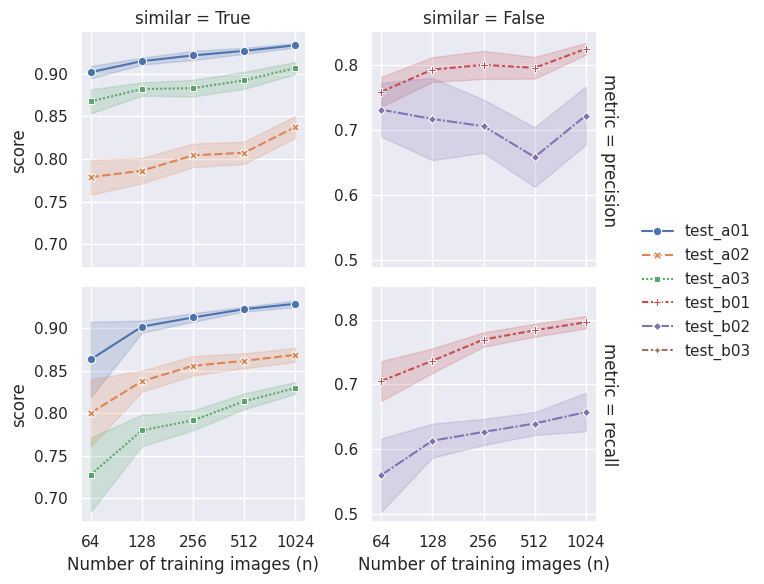

In [51]:
sns.set("notebook")
g = sns.FacetGrid(
    data_s1,
    row="metric",
    col="similar",
    # col_wrap=2,
    margin_titles=True,
    sharey="col",
)
g.map_dataframe(sns.lineplot, 
    x="n", y="score", 
    hue="split", style="split",
    hue_order=splits_s1,
    style_order=splits_s1,
    err_style="band", errorbar=("se", 2),
    markers=True,
    # palette=["Grey", "#FF1F5B", "#00B000", "#009ADE", "#AF58BA"],
    )
# title
# g.figure.suptitle("Model Generalization in each Data Configuration")
g.set(
    xscale="log",
    xticks=[2**i for i in range(6, 11)],
    xticklabels=[2**i for i in range(6, 11)],
    xlabel="Number of training images (n)",)
g.figure.subplots_adjust(right=1.2)
g.add_legend()
g.figure.set_size_inches(8, 6)
g.savefig(os.path.join(DIR_SRC, 'results_study1.png'), dpi=300)


## Study 2

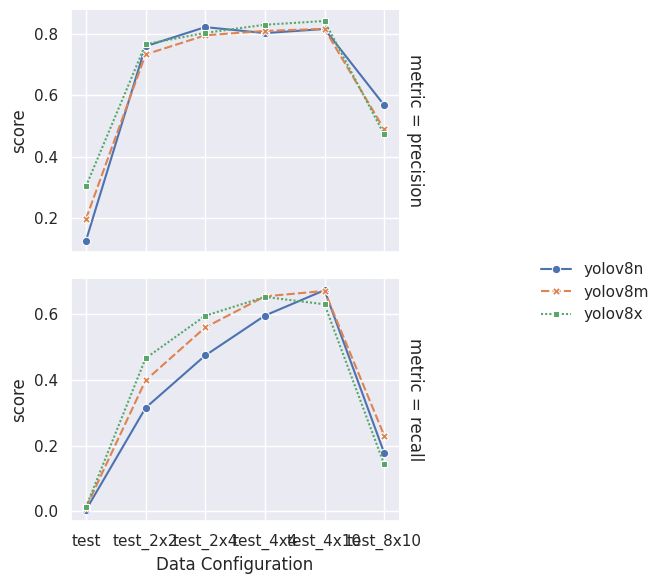

In [50]:
data_s2 = data_fig.\
        query("study == 2").\
        query("metric in ['precision', 'recall']").\
            query("model != 'yolov9c' and model != 'yolov9e'")
# lineplot
# x: split (test, test_2x2, test_2x4, test_4x4, test_4x10, test_8x10)
# y: score
# hue: model
# style: model
# facet_grid: metric
sns.set("notebook")
g = sns.FacetGrid(
    data_s2,
    row="metric",
    # col="model",
    margin_titles=True,
    sharey=False,
)
g.map_dataframe(sns.lineplot,
    x="split", y="score",
    hue="model", style="model",
    err_style="band", errorbar=("se", 2),
    markers=True,
    # palette=["Grey", "#FF1F5B", "#00B000", "#009ADE", "#AF58BA"],
    )
# title
g.set(xlabel="Data Configuration",)

g.add_legend()
g.figure.set_size_inches(8, 6)
# dpi
g.savefig(os.path.join(DIR_SRC, 'results_study2.png'), dpi=300)
